# HyDE

HyDE手法を試す  
Semantic Chunkingによる文章のChunk分割を実施

In [1]:
import os
import pandas as pd
import openai
import datetime
import tiktoken
from sudachipy import tokenizer
from sudachipy import dictionary
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

In [2]:
# OpenAI APIキーを設定
openai.api_key = input()

## テキスト読み込み

In [3]:
novel_file_path = "../data/novels_preprocess_2/works/"

In [4]:
# .txt ファイルを読み込み、ドキュメントをリスト化
documents = []
for filename in os.listdir(novel_file_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(novel_file_path, filename)
        loader = TextLoader(file_path, encoding="utf-8")
        documents.extend(loader.load())

In [5]:
documents

[Document(metadata={'source': '../data/novels_preprocess_2/works/カインの末裔.txt'}, page_content='（一）\n長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。\n大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。\n北海道の冬は空まで逼っていた。\n蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っていった。\n寒い風だ。\n見上げると八合目まで雪になったマッカリヌプリは少し頭を前にこごめて風に歯向いながら黙ったまま突立っていた。\n昆布岳の斜面に小さく集った雲の塊を眼がけて日は沈みかかっていた。\n草原の上には一本の樹木も生えていなかった。\n心細いほど真直な一筋道を、彼れと彼れの妻だけが、よろよろと歩く二本の立木のように動いて行った。\n二人は言葉を忘れた人のようにいつまでも黙って歩いた。\n馬が溺りをする時だけ彼れは不性無性に立どまった。\n妻はその暇にようやく追いついて背の荷をゆすり上げながら溜息をついた。\n馬が溺りをすますと二人はまた黙って歩き出した。\n「ここらおやじ（熊の事）が出るずら」\n四里にわたるこの草原の上で、たった一度妻はこれだけの事をいった。\n慣れたものには時刻といい、所柄といい熊の襲来を恐れる理由があった。\n彼れはいまいましそうに草の中に唾を吐き捨てた。\n草原の中の道がだんだん太くなって国道に続く所まで来た頃には日は暮れてしまっていた。\n物の輪郭が円味を帯びずに、堅いままで黒ずんで行くこちんとした寒い晩秋の夜が来た。\n着物は薄かった。\nそして二人は餓え切っていた。\n妻は気にして時々赤坊を見た。\n生きているのか死んでいるのか、とにかく赤坊はいびきも立てないで首を右の肩にがくりと垂れたまま黙っていた。\n国道の上にはさすがに人影が一人二人動いていた。\n大抵は市街地に出て一杯飲んでいたのらしく、行違いにしたたか酒の香を送ってよこすものもあった。\n彼れは酒の香をかぐと急にえぐられるような渇きと食欲とを覚えて、すれ違った男を見送ったりした

In [6]:
page_contents_list = [doc.page_content for doc in documents]
page_contents = "\n".join(page_contents_list)

In [7]:
sentences_list = page_contents.split("\n")

In [8]:
sentences_list

['（一）',
 '長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。',
 '大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。',
 '北海道の冬は空まで逼っていた。',
 '蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っていった。',
 '寒い風だ。',
 '見上げると八合目まで雪になったマッカリヌプリは少し頭を前にこごめて風に歯向いながら黙ったまま突立っていた。',
 '昆布岳の斜面に小さく集った雲の塊を眼がけて日は沈みかかっていた。',
 '草原の上には一本の樹木も生えていなかった。',
 '心細いほど真直な一筋道を、彼れと彼れの妻だけが、よろよろと歩く二本の立木のように動いて行った。',
 '二人は言葉を忘れた人のようにいつまでも黙って歩いた。',
 '馬が溺りをする時だけ彼れは不性無性に立どまった。',
 '妻はその暇にようやく追いついて背の荷をゆすり上げながら溜息をついた。',
 '馬が溺りをすますと二人はまた黙って歩き出した。',
 '「ここらおやじ（熊の事）が出るずら」',
 '四里にわたるこの草原の上で、たった一度妻はこれだけの事をいった。',
 '慣れたものには時刻といい、所柄といい熊の襲来を恐れる理由があった。',
 '彼れはいまいましそうに草の中に唾を吐き捨てた。',
 '草原の中の道がだんだん太くなって国道に続く所まで来た頃には日は暮れてしまっていた。',
 '物の輪郭が円味を帯びずに、堅いままで黒ずんで行くこちんとした寒い晩秋の夜が来た。',
 '着物は薄かった。',
 'そして二人は餓え切っていた。',
 '妻は気にして時々赤坊を見た。',
 '生きているのか死んでいるのか、とにかく赤坊はいびきも立てないで首を右の肩にがくりと垂れたまま黙っていた。',
 '国道の上にはさすがに人影が一人二人動いていた。',
 '大抵は市街地に出て一杯飲んでいたのらしく、行違いにしたたか酒の香を送ってよこすものもあった。',
 '彼れは酒の香をかぐと急にえぐられるような渇きと食欲とを覚えて、すれ違った男を見送ったりしたが、いまいましさに吐き捨て

In [9]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences_list)]
sentences[:3]

[{'sentence': '（一）', 'index': 0},
 {'sentence': '長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。', 'index': 1},
 {'sentence': '大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。',
  'index': 2}]

In [10]:
len(sentences)

7750

## Embedding

In [11]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [12]:
# OpenAIの埋め込みモデルを使ってドキュメントをベクトル化
embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\900527064.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)


In [13]:
embeddings = embedding.embed_documents([x['combined_sentence'] for x in sentences])

In [14]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

## 類似度比較

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [16]:
distances, sentences = calculate_cosine_distances(sentences)
distances[:3]

[0.05198420277114113, 0.026729114326370818, 0.04455227061023881]

### 類似度確認

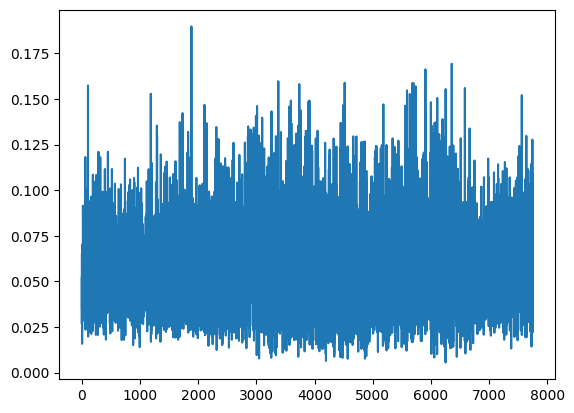

In [17]:
import matplotlib.pyplot as plt

plt.plot(distances)

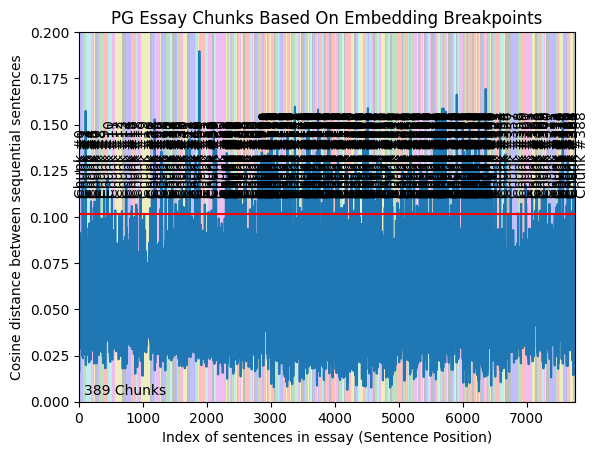

In [18]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

## チャンク分割

In [19]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

In [20]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
（一） 長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。 大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。 北海道の冬は空まで逼っていた。 蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っ
...
る時の事を思った。 妻は吸い取られるように暖かそうな火の色に見惚れていた。 二人は妙にわくわくした心持ちになった。 蹄鉄屋の先きは急に闇が濃かくなって大抵の家はもう戸じまりをしていた。 荒物屋を兼ねた居酒屋らしい一軒から食物の香と男女のふざけ返った濁声がもれる外には、真直な家並は廃村のように寒さの前にちぢこまって、電信柱だけが、けうとい唸りを立てていた。 彼れと馬と妻とは前の通りに押黙って歩いた。


Chunk #1
歩いては時折り思い出したように立停った。 立停ってはまた無意味らしく歩き出した。 四、五町歩いたと思うと彼らはもう町はずれに来てしまっていた。 道がへし折られたように曲って、その先きは、真闇な窪地に、急な勾配を取って下っていた。 彼らはその突角まで行ってまた立停った。 遙か下の方からは、うざうざするほど繁り合った濶葉樹林に風の這入る音の外に、シリベシ河のかすかな水の音だけが聞こえていた。 「聞いて
...
てた。 彼れはそれにも気を取られていた。 上框に腰をかけていたもう一人の男はやや暫らく彼れの顔を見つめていたが、浪花節語りのような妙に張りのある声で突然口を切った。 「お主は川森さんの縁のものじゃないんかの。どうやら顔が似とるじゃが」 今度は彼れの返事も待たずに長顔の男の方を向いて、 「帳場さんにも川森から話いたはずじゃがの。主がの血筋を岩田が跡に入れてもらいたいいうてな」 また彼れの方を向いて、




In [21]:
len(chunks)

389

## 以下、通常のRAG

In [22]:
# FAISSでベクトルストアを作成
vectorstore = FAISS.from_texts(chunks, embedding)

In [23]:
# SudachiPyの初期設定
tokenizer_obj = dictionary.Dictionary().create()

In [44]:
# 6. 回答を50トークン以内に制限し、引用を含むプロンプトを作成
prompt_template = """あなたは正確性の高いQAシステムです。
事前知識ではなく、常に提供されたコンテキスト情報を使用して質問に回答してください。
以下のルールに従って回答してください。:
1. 事前知識は使わず、コンテキストから得られる情報のみを使用して回答してください。
2. 回答内で指定されたコンテキストを直接参照しないでください。
3. 「コンテキストに基づいて、...」や「コンテキスト情報は...」、またはそれに類するような記述は避けてください。
4. 回答は50トークン以内で簡潔に回答してください。
5. コンテキストから具体的な回答ができない場合は「分かりません」と回答してください。
6. ハルシネーションを起こさないよう、少しでも自信がない場合は「分かりません」と回答してください。

コンテキスト: {context}
質問: {question}
回答:"""

In [25]:
# OpenAIの言語モデルを設定（ここではGPT-3を使用）
llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\1591884372.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)


In [41]:
# LLMを使って要約を行う関数
def generate_hypothetical_answer(question: str) -> str:

    hyde_prompt = PromptTemplate(
        input_variables=["question"],
        template=
            """質問に対して仮想的な回答を作成してください。以下の質問に答えてください:
               質問: {question}
               回答:"""
    )
    chain = hyde_prompt | llm

    response = chain.invoke(
        {"question": question}
    )
    return response.content

In [29]:
# Retrieverとしてベクトルストアを設定し、top_kを設定
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

In [45]:
def hyde_rag_system(query):
    # 仮想的な回答を生成
    hypothetical_answer = generate_hypothetical_answer(query)
    print(f"仮想的な回答: {hypothetical_answer}")
    
    # 生成された仮想回答をクエリとしてベクトル検索
    relevant_docs = vectorstore.similarity_search(hypothetical_answer, k=10)
    prompt = PromptTemplate(template=prompt_template, input_variables=["relevant_docs", "query"])
    
    # 関連するドキュメントを基に最終的な回答を得る
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",  # 関連ドキュメントをまとめて渡す
        retriever=vectorstore.as_retriever(),
        return_source_documents=True,
        chain_type_kwargs={"prompt": prompt}
    )
    
    # クエリに基づいた最終回答を取得
    result = qa_chain({"query": query, "context": relevant_docs})
    final_answer = result["result"]
    source_docs = result["source_documents"]

    return final_answer, source_docs

## 質問ファイルを読み込んでQ&Aを作成

In [31]:
# 提供されたCSVファイルを読み込み
query_df = pd.read_csv("../data/query.csv", encoding="utf-8")

In [32]:
query_df.head()

,index,problem
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？
4,5,小説「芽生」で出てくる国名は何種類ですか？


In [46]:
answers = []
evidences = []

for _, row in query_df.iterrows():
    print(_)
    query = row["problem"]
    print(query)
    final_answer, source_docs = hyde_rag_system(query)
    print(final_answer)
    answers.append(final_answer)
    evidences.append(source_docs)

0
競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？
仮想的な回答: 競漕会の三日前のレースコースでの結果について、農科と文科のチームのタイムを比較したところ、農科チームが文科チームよりも15秒早かったという結果が出ました。


C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\2099534543.py:20: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  result = qa_chain({"query": query, "context": relevant_docs})


農科が5分20秒以上かかり、文科は5分15秒かかったため、文科が農科よりも約5秒早かったです。
1
骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。
仮想的な回答: 回答: 骸骨男の正体は、作中で明確に特定されていないため、氏名は言及されていません。物語の中では、彼の正体についてさまざまな推測がなされていることが多いですが、具体的な名前は明らかにされていないことが多いです。
分かりません。
2
骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？
仮想的な回答: 骸骨男がバスの中に足跡を一切残さずに抜け出した可能性として、いくつかの仮説が考えられます。

1. **浮遊能力**: 骸骨男は超自然的な力を持ち、地面に触れずに浮遊して移動できたため、足跡を残さなかった。

2. **特殊な装置**: 彼は特殊な装置を使って短距離の瞬間移動を行い、バスの外に直接移動したため、足跡が残らなかった。

3. **計画的な脱出**: バスの中で他の乗客や運転手の注意を巧みにそらし、車内の構造や設備を利用して足跡を残さずに抜け出した。

4. **無形化**: 骸骨男は一時的に無形化する能力を持っており、バスのドアや窓を通過しても物理的な痕跡を残さずに移動できた。

これらの仮説は、物語の中での設定や骸骨男の能力によりますが、いずれにせよ彼の神秘的な性質を強調するものです。
バスの中に隠されたばね仕掛けの落とし穴を利用して抜け出しました。
3
殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？
仮想的な回答: 回答: 兄が殺人罪で裁判にかけられた理由は、彼がある事件の主要な容疑者とされているからです。この事件では、被害者が何者かによって命を奪われ、その現場付近や状況証拠が兄を指し示しているとされています。捜査当局は、兄が被害者と何らかの個人的な対立や恨みを抱えていた可能性があると考えており、その動機や事件当日の行動について詳しく調査を進めています。裁判では、検察が証拠を提示し、弁護側が無罪を主張する中で、真実が明らかにされることが期待されています。
分かりません。
4
小説「芽生」で出てくる国名は何種類ですか？
仮想的な回答: 申し訳ありませんが、小説「芽生」に関する具体的な国名についての情報は手元にありません。「芽生」がどの作品を指している

In [47]:
# DataFrameに回答と証拠を追加
query_df['full_answer'] = answers
query_df['evidence'] = evidences

In [48]:
replace_dict = {
        "\n": "",
        "\r": "",
    }

query_df = query_df.replace(
        {"evidence": replace_dict},
        regex=True
    )

In [49]:
query_df.head(10)

,index,problem,full_answer,evidence
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？,農科が5分20秒以上かかり、文科は5分15秒かかったため、文科が農科よりも約5秒早かったです。,[page_content='三 競漕の日はだんだん近づいて来る。 その一週間ほど前に学習院...
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。,分かりません。,[page_content='「アッ、骸骨……。」 それは、あの骸骨男でした。 いつも着てい...
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？,バスの中に隠されたばね仕掛けの落とし穴を利用して抜け出しました。,[page_content='とつぶやいています。 「骸骨男がいなくなったのですか。」 井上...
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？,分かりません。,[page_content='第四幕。 場面――一郎の家の中。 客間に三人が正座している。 ...
4,5,小説「芽生」で出てくる国名は何種類ですか？,二種類です。,[page_content='眺め入りながら、 「芽生は枯れた、親木も一緒に枯れかかって来た...
5,6,武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？,分かりません。,[page_content='この事いずれよりか伝わりて、浪子に達せし時、幾は限りなくよろこ...
6,7,小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたい...,分かりません。,[page_content='小林君は、 「はい、もうじき帰ります。」 と答えましたが、笠原...
7,8,「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？,一回です。,[page_content='そしていつもよりは活気づいて艇庫に船を蔵めた。 夕飯には褒賞の...
8,9,文中に登場するカタカナ表記された北海道の地名を全て挙げてください。,マッカリヌプリ、昆布岳、内浦湾,[page_content='赤黒子の前には小形の手帳を広げたり、鉛筆を添えて。 番地官名な...
9,10,兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？,約七年経過したと考えられます。,[page_content='そして、仏様に捧げる祈りの文句を繰り返した。 木魚の音や読経は...


In [50]:
# LLMを使って要約を行う関数
def summarize_answer(problem: str, full_answer: str, evidence: str) -> str:

    summarize_prompt = PromptTemplate(
        input_variables=["problem", "full_answer", "evidence"],
        template=
            """以下のQuestionに対するAnswerの文章をEvidenceを元に50文字以内に収まるように簡潔に答え直してください。
            50文字以内に収まらない場合、要約して一言で答えてください。
            回答だけを答えてください。
                f"Question: {problem}\n\n"
                f"Answer: {full_answer}\n"
                f"Evidence: {evidence}\n"
            回答:"""
    )
    chain = summarize_prompt | llm

    response = chain.invoke(
        {"problem": problem, "full_answer": full_answer, "evidence": evidence}
    )
    return response.content

In [51]:
# tiktokenとgpt-4のトークナイザーを取得
enc = tiktoken.encoding_for_model("gpt-4-2024-08-06")

# query_df の "answer" 列のトークン数を計算し、50トークンを超える場合は要約を行う関数
def check_and_summarize_answers(query_df: pd.DataFrame) -> pd.DataFrame:
    def summarize_if_needed(problem: str, full_answer: str, evidence: str) -> str:
        # トークン数を計算
        token_count = len(enc.encode(full_answer))
        print(token_count)
        
        # トークン数が50を超えた場合は要約する
        if token_count > 50:
            # LLMを使って要約
            summarized_answer = summarize_answer(problem, full_answer, evidence)
            return summarized_answer
        return full_answer

    # "answer" 列に対して処理を適用
    query_df["answer"] = query_df["full_answer"]
    for i in range(len(query_df.index)):
        query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
    return query_df

In [52]:
query_df = check_and_summarize_answers(query_df)

47
7
35
7
7
7
7
4
20
17
7
5
39
110


C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

6
25
7
8
7
7
7
8
39
7
8
6
13
16
7
30
83


C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

9
7
89


C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

7
7
7
7
20
7
7
7
7
7
23
7
7
7
14
7
7
7
7
7
7
11
52
7
7
9


C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_47784\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [53]:
query_df.head(20)

,index,problem,full_answer,evidence,answer
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？,農科が5分20秒以上かかり、文科は5分15秒かかったため、文科が農科よりも約5秒早かったです。,[page_content='三 競漕の日はだんだん近づいて来る。 その一週間ほど前に学習院...,農科が5分20秒以上かかり、文科は5分15秒かかったため、文科が農科よりも約5秒早かったです。
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。,分かりません。,[page_content='「アッ、骸骨……。」 それは、あの骸骨男でした。 いつも着てい...,分かりません。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？,バスの中に隠されたばね仕掛けの落とし穴を利用して抜け出しました。,[page_content='とつぶやいています。 「骸骨男がいなくなったのですか。」 井上...,バスの中に隠されたばね仕掛けの落とし穴を利用して抜け出しました。
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？,分かりません。,[page_content='第四幕。 場面――一郎の家の中。 客間に三人が正座している。 ...,分かりません。
4,5,小説「芽生」で出てくる国名は何種類ですか？,二種類です。,[page_content='眺め入りながら、 「芽生は枯れた、親木も一緒に枯れかかって来た...,二種類です。
5,6,武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？,分かりません。,[page_content='この事いずれよりか伝わりて、浪子に達せし時、幾は限りなくよろこ...,分かりません。
6,7,小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたい...,分かりません。,[page_content='小林君は、 「はい、もうじき帰ります。」 と答えましたが、笠原...,分かりません。
7,8,「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？,一回です。,[page_content='そしていつもよりは活気づいて艇庫に船を蔵めた。 夕飯には褒賞の...,一回です。
8,9,文中に登場するカタカナ表記された北海道の地名を全て挙げてください。,マッカリヌプリ、昆布岳、内浦湾,[page_content='赤黒子の前には小形の手帳を広げたり、鉛筆を添えて。 番地官名な...,マッカリヌプリ、昆布岳、内浦湾
9,10,兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？,約七年経過したと考えられます。,[page_content='そして、仏様に捧げる祈りの文句を繰り返した。 木魚の音や読経は...,約七年経過したと考えられます。


In [54]:
# 必要な列（id, answer, evidence）をヘッダなしでCSVに書き出し
query_df[['index', 'answer', 'evidence']].to_csv(
    "../submit/predictions.csv",
    index=False,
    header=False,
    encoding="utf-8-sig"
)

In [55]:
# backup
dt_now = datetime.datetime.now()
ymdm = dt_now.strftime("%Y%m%d-%H%M")

query_df[['index', 'problem', 'full_answer', 'answer', 'evidence']].to_csv(
    f"../submit/{ymdm}_predictions.csv",
    index=False,
    header=True,
    encoding="utf-8-sig"
)